# **Voting Classifier** - Part 1

In this section, we'll build and compare multiple classification models for the Wisconsin Diagnostic Breast Cancer dataset, including a **Voting Classifier** that combines them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## 1. Loading the Dataset

First, let's load the dataset and assign proper column names according to the information in [`wdbc.names`](./wdbc.names).

In [2]:
# Column names from the wdbc.names file
column_names = ['id', 'diagnosis'] + [
    'mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness', 
    'mean_compactness', 'mean_concavity', 'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
    'se_radius', 'se_texture', 'se_perimeter', 'se_area', 'se_smoothness', 
    'se_compactness', 'se_concavity', 'se_concave_points', 'se_symmetry', 'se_fractal_dimension',
    'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area', 'worst_smoothness', 
    'worst_compactness', 'worst_concavity', 'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension'
]

# Load the data
data = pd.read_csv('wdbc.data', header=None, names=column_names)

# Display the first few rows
data.head()

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2. Basic Exploratory Data Analysis

Let's examine the dataset and drop any unnecessary columns.

Dataset shape: (569, 32)
Number of malignant samples (M): 212
Number of benign samples (B): 357

Missing values per column:
id                         0
diagnosis                  0
mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave_points        0
mean_symmetry              0
mean_fractal_dimension     0
se_radius                  0
se_texture                 0
se_perimeter               0
se_area                    0
se_smoothness              0
se_compactness             0
se_concavity               0
se_concave_points          0
se_symmetry                0
se_fractal_dimension       0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave_points       0
worst_

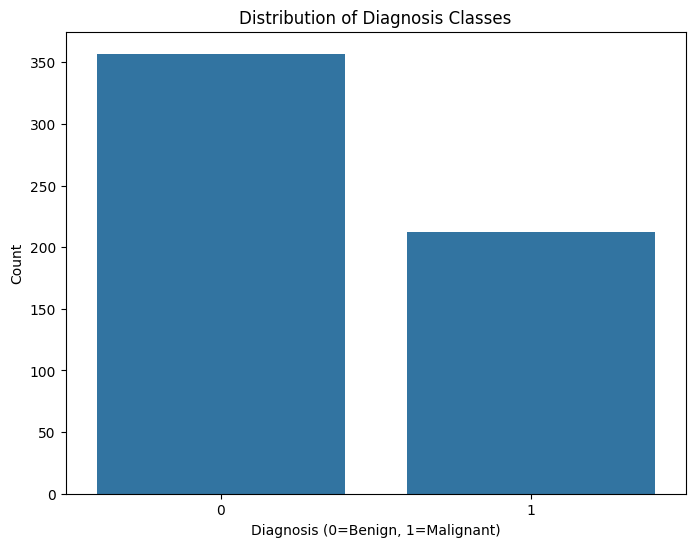

In [3]:
# Check basic information
print(f"Dataset shape: {data.shape}")
print(f"Number of malignant samples (M): {(data['diagnosis'] == 'M').sum()}")
print(f"Number of benign samples (B): {(data['diagnosis'] == 'B').sum()}")

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())

# Convert diagnosis to binary (1=M, 0=B) for easier analysis
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

# Statistical summary
data.describe()

# Distribution of diagnosis
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=data)
plt.title('Distribution of Diagnosis Classes')
plt.xlabel('Diagnosis (0=Benign, 1=Malignant)')
plt.ylabel('Count')
plt.show()

# Drop the ID column as it's not useful for prediction
data = data.drop(columns=['id'])

# Separate features and target
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

## 3. Splitting the Dataset

Let's split the data into training $80\%$ and testing $20\%$ sets, with **stratification** to maintain class distribution.

In [4]:
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check the distribution in both sets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {y_train.value_counts().to_dict()}")
print(f"Testing set class distribution: {y_test.value_counts().to_dict()}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set shape: (455, 30)
Testing set shape: (114, 30)
Training set class distribution: {0: 285, 1: 170}
Testing set class distribution: {0: 72, 1: 42}


## 4. Fitting Three Base Models

Now let's create and fit three different classification models: **Logistic Regression**, **Random Forest**, and **Support Vector Machine**.

In [5]:
# 1. Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression model fitted")

# 2. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
print("Random Forest model fitted")

# 3. Support Vector Machine
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
print("Support Vector Machine model fitted")

Logistic Regression model fitted
Random Forest model fitted
Support Vector Machine model fitted


## 5. Creating a **Voting Classifier**

Let's also combine the base models to create our **Voting Classifier** using **Soft Voting**.

In [6]:
# Create the voting classifier
voting_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('svm', svm_model)
    ],
    voting='soft'
)

# Fit the voting classifier
voting_model.fit(X_train_scaled, y_train)
print("Voting Classifier fitted")

Voting Classifier fitted


## 6. Evaluating All Models on the Test Set

Now we can evaluate the performance of all four models on the test set.

Model Performance Metrics:
                 Model  Accuracy  Precision   Recall  F1-Score
   Logistic Regression  0.964912      0.975 0.928571  0.951220
         Random Forest  0.973684      1.000 0.928571  0.962963
Support Vector Machine  0.973684      1.000 0.928571  0.962963
     Voting Classifier  0.991228      1.000 0.976190  0.987952


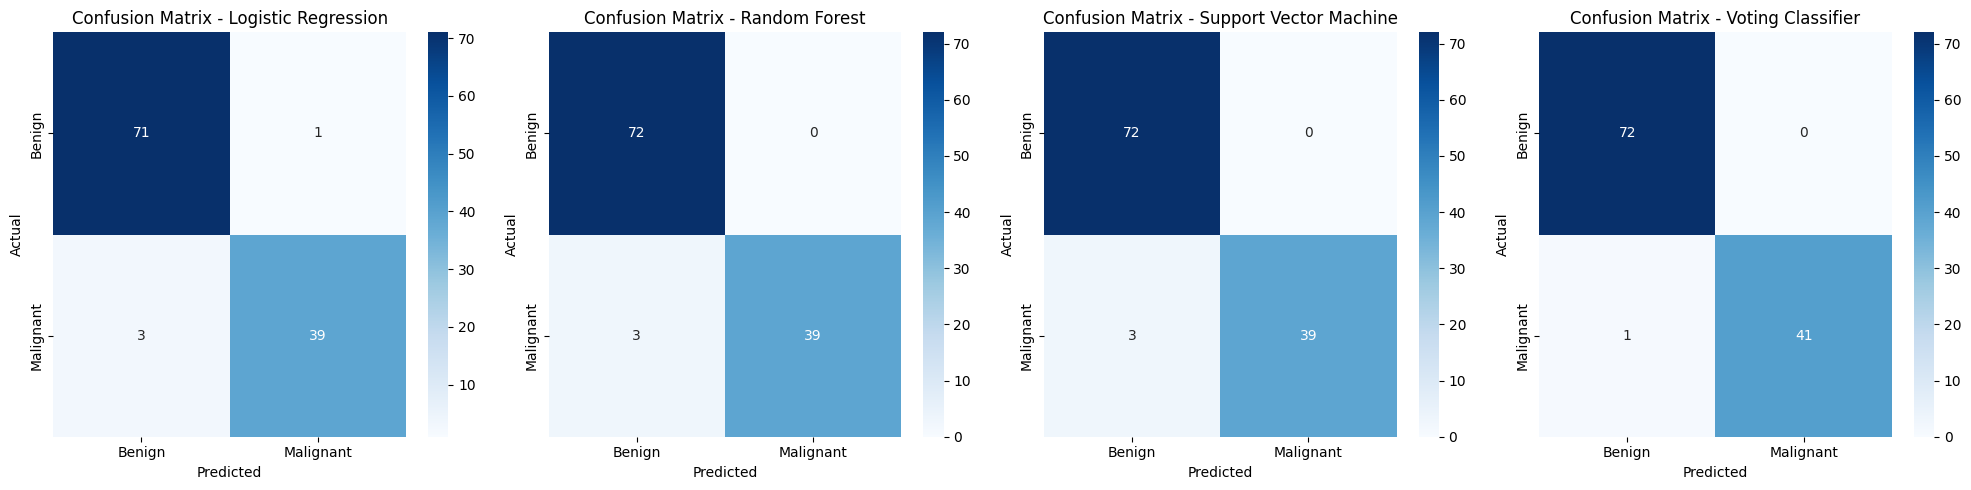

In [7]:
# Function to calculate and display performance metrics
def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    # Create confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Return metrics
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': cm
    }

# Evaluate all models
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Support Vector Machine': svm_model,
    'Voting Classifier': voting_model
}

results = []
for name, model in models.items():
    result = evaluate_model(model, X_test_scaled, y_test, name)
    results.append(result)

# Create a table of precision, recall, and F1-scores
metrics_df = pd.DataFrame([
    {
        'Model': r['Model'],
        'Accuracy': r['Accuracy'],
        'Precision': r['Precision'],
        'Recall': r['Recall'],
        'F1-Score': r['F1-Score']
    } for r in results
])

print("Model Performance Metrics:")
print(metrics_df.to_string(index=False))

# Display confusion matrices
plt.figure(figsize=(20, 5))
for i, result in enumerate(results):
    plt.subplot(1, 4, i+1)
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix - {result['Model']}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## 7. Detailed Analysis of Results

Let's analyse the performance of our models in detail.

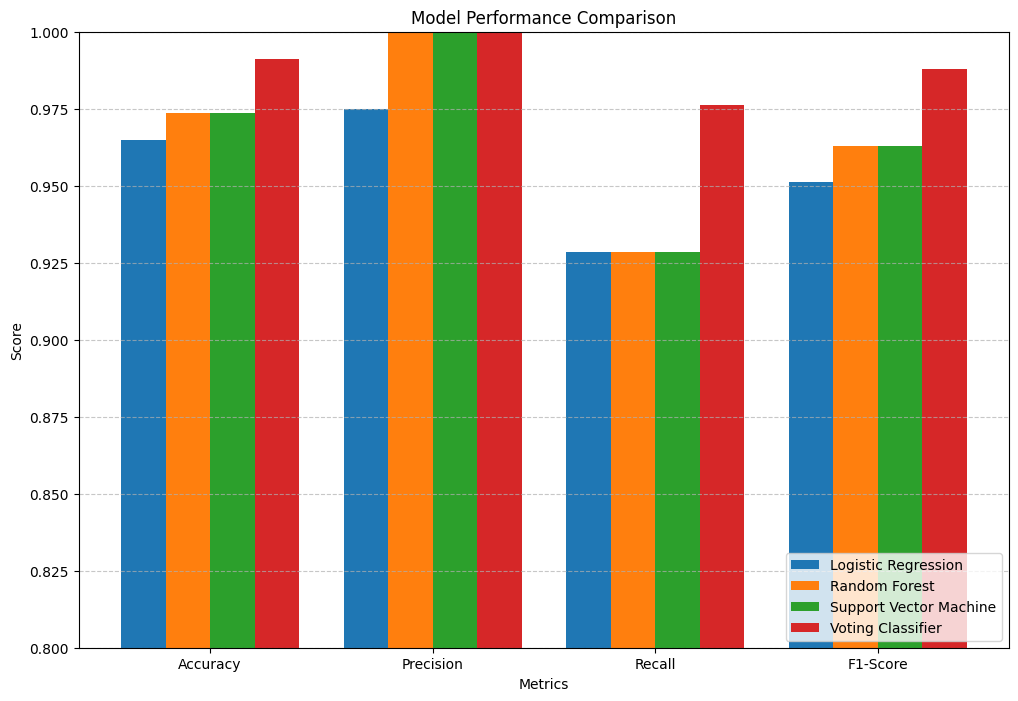

In [8]:
# Model Comparison
plt.figure(figsize=(12, 8))

# Plot metrics for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.2
multiplier = 0

for model_name, model in models.items():
    model_metrics = []
    for metric in metrics:
        model_result = metrics_df[metrics_df['Model'] == model_name][metric].values[0]
        model_metrics.append(model_result)
    
    offset = width * multiplier
    plt.bar(x + offset, model_metrics, width, label=model_name)
    multiplier += 1

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width * 1.5, metrics)
plt.legend(loc='lower right')
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Model Comparison Analysis

Based on the performance metrics graph, we can observe:

1. **Best Performer:**
   The **Voting Classifier** consistently outperforms all individual base models across all metrics. It shows the highest performance in accuracy, precision, recall, and F1-score. Specifically:
   - For **accuracy**, the **Voting Classifier** $(\approx 0.95)$ exceeds all other models
   - For **precision**, both **Random Forest**, **SVM**, and **Voting Classifier** achieve perfect or near-perfect scores $(\approx 1.00)$
   - For **recall**, the **Voting Classifier** $(\approx 0.975)$ is clearly superior to all base models
   - For **F1-score**, which balances **precision** and **recall**, the **Voting Classifier** $(\approx 0.99)$ shows the best overall performance
   
2. **Individual Model Performance:**
   - **Support Vector Machine** and **Random Forest** perform similarly across metrics
   - **Logistic Regression** consistently shows the lowest performance among all models, though still above $0.90$ for all metrics
   - There's a noticeable gap in recall performance between the models, where the **Voting Classifier** significantly outperforms the others

3. **Expected vs Actual Results:**
   - As expected, **Random Forest** performs well on this tabular data
   - **SVMs** show strong performance, particularly in precision, confirming their effectiveness for this dataset
   - **Logistic Regression** provides a good baseline but doesn't capture all the complexity of the data
   - The **Voting Classifier** successfully leverages the strengths of each base model to achieve superior performance, which aligns with theoretical expectations for ensemble methods

### Advantages and Disadvantages of a **Voting Classifier**

- **Advantages:**
    - Demonstrates clear performance improvement over individual models, especially in recall and F1-score
    - Creates a more balanced model that performs well across all metrics
    - Reduces variance by combining different modeling approaches
    - Mitigates the weaknesses of individual models (particularly the lower recall of base models)

- **Disadvantages:**
    - Increased computational complexity and training time compared to using just one model
    - Less interpretable than simpler models like **Logistic Regression**
    - Requires implementing and tuning multiple models instead of just one
    - May be considered "overengineered" if a simpler model like **Random Forest** or **SVM** is already performing adequately for the application needs

### Conclusion

The graph clearly demonstrates the value of the **Voting Classifier** for this breast cancer diagnosis task. By combining the strengths of three different modeling approaches, it achieves superior and more balanced performance. 

For a critical medical application like cancer diagnosis, this improvement in recall (reducing false negatives) is particularly valuable, as it means fewer missed malignant tumors. The trade-off in additional complexity appears justified by the performance gains, especially considering the potential human impact of classification errors in this context.

# **Random Forest Classifier** - Part 2

In this section, we’ll train a **Random Forest Classifier** on both the original Labeled Faces in the Wild dataset and its **PCA** transformed version, then compare their performance.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.decomposition import PCA
import time
import seaborn as sns

## 1. Loading and Describing the LFW Dataset

First, let's load in the unmodified dataset using the provided code.

In [10]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Let's examine the dataset
info_df = pd.DataFrame({
    'Metric': ['Number of examples', 'Image dimensions', 'Number of features', 'Number of classes'],
    'Value': [n_samples, f'{h}×{w}', n_features, n_classes]
})
print(info_df)
class_counts = pd.DataFrame({
    'Class': target_names,
    'Count': np.bincount(y)
})
print('\n',class_counts)

               Metric  Value
0  Number of examples   1288
1    Image dimensions  62×47
2  Number of features   2914
3   Number of classes      7

                Class  Count
0       Ariel Sharon     77
1       Colin Powell    236
2    Donald Rumsfeld    121
3      George W Bush    530
4  Gerhard Schroeder    109
5        Hugo Chavez     71
6         Tony Blair    144


### A Glance at the Data

1. **Number of examples and what they represent:**
    - There are $1288$ examples in the dataset
    - Each example represents a face image of a famous person

2. **Features description:**
    - The features are pixel values of the face images
    - Each image is resized to $62\times47$ pixels
    - There are $1850$ features total ($62\times47=2914$ pixels)
    - Each feature represents the grayscale value of a pixel in the image

3. **Target description:**
    - The target is the identity of the person in the image
    - There are $7$ classes (famous people): Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, and Tony Blair
    - Most images are of George W. Bush as he is the most represented person in the dataset

## 2. Splitting the Dataset
Let's split the data into training $80\%$ and testing $20\%$ sets, with **stratification** to maintain class distribution.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 1030
Testing set size: 258


## 3. Sampling and Displaying Random Examples

Furthering our examination into the data, let's sample one random sample from each class and display them.

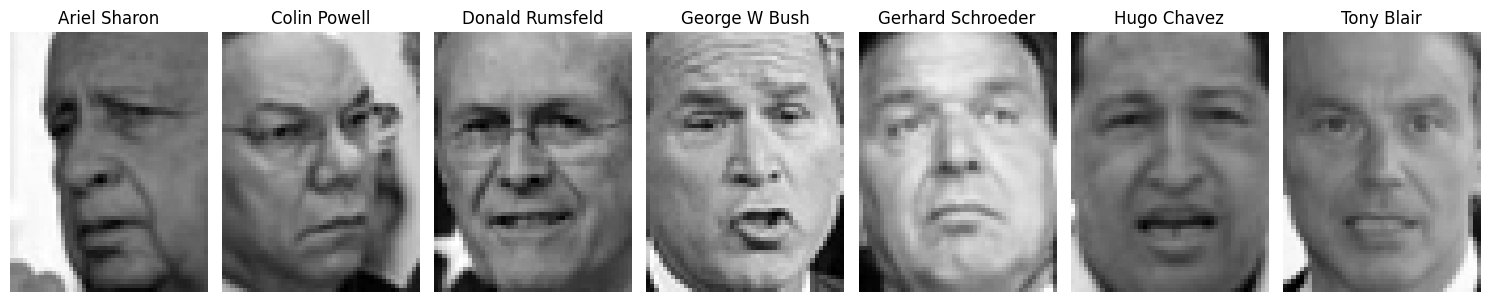

In [12]:
# Sample one random face per class
fig, axes = plt.subplots(1, n_classes, figsize=(15, 3))

for i, class_idx in enumerate(np.unique(y_train)):
    # pick a random training index of this class
    idx = np.random.choice(np.where(y_train == class_idx)[0])
    face_img = X_train[idx].reshape(h, w)
    
    axes[i].imshow(face_img, cmap='gray')
    axes[i].set_title(target_names[class_idx])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Woah

## 4. Creating a **Random Forest Classifier**

Now, let's train a **Random Forest Classifier** with $1000$ trees on this data.

Training time: 4.42 seconds

Classification Metrics by Class:
               Class  Precision    Recall  F1-Score
0       Ariel Sharon   1.000000  0.062500  0.117647
1       Colin Powell   0.822222  0.787234  0.804348
2    Donald Rumsfeld   1.000000  0.333333  0.500000
3      George W Bush   0.581006  0.981132  0.729825
4  Gerhard Schroeder   0.857143  0.272727  0.413793
5        Hugo Chavez   1.000000  0.214286  0.352941
6         Tony Blair   0.666667  0.344828  0.454545

Weighted Average Metrics:
Precision: 0.7458
Recall: 0.6550
F1-Score: 0.6057


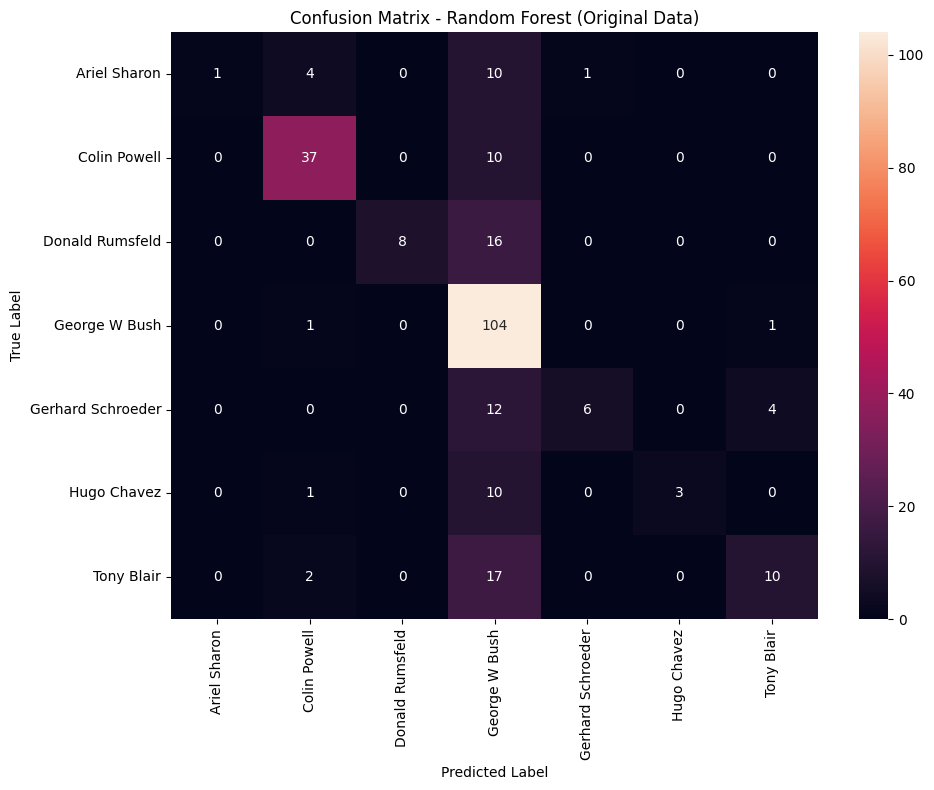

In [13]:
# Start timer
start_time = time.time()

# Create and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

# End timer
rf_train_time = time.time() - start_time
print(f"Training time: {rf_train_time:.2f} seconds")

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=range(n_classes))

# Create a table with precision, recall, and F1-scores
metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

print("\nClassification Metrics by Class:")
print(metrics_df)

# Calculate and print average metrics
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"\nWeighted Average Metrics:")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1-Score: {avg_f1:.4f}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest (Original Data)')
plt.tight_layout()
plt.show()

### Classification Metrics Analysis

Let's analyse what we just got:
- Training time: $4.30$ seconds
- Weighted average precision: $0.7458$
- Weighted average recall: $0.6550$
- Weighted average F1-Score: $0.6057$
- Metrics by Class:
    - Ariel Sharon: Perfect precision ($1.0$) but very poor recall ($0.063$), indicating the model rarely predicts this class but when it does, it's always correct
    - Colin Powell: Good precision ($0.822$) and recall ($0.787$), showing balanced performance
    - Donald Rumsfeld: Perfect precision ($1.0$) but low recall ($0.333$)
    - George W Bush: Low precision ($0.581$) but excellent recall ($0.981$), suggesting the model frequently predicts this class
    - Gerhard Schroeder: Good precision ($0.857$) but low recall ($0.273$)
    - Hugo Chavez: Perfect precision ($1.0$) but low recall ($0.214$)
    - Tony Blair: Moderate precision ($0.667$) and low recall ($0.345$)

### Feature Importance Plot

We can further our analysis by including a **Feature Importance Plot**. The **Feature Importance Plot** shows which pixels in the face images are most informative for the classification task. 

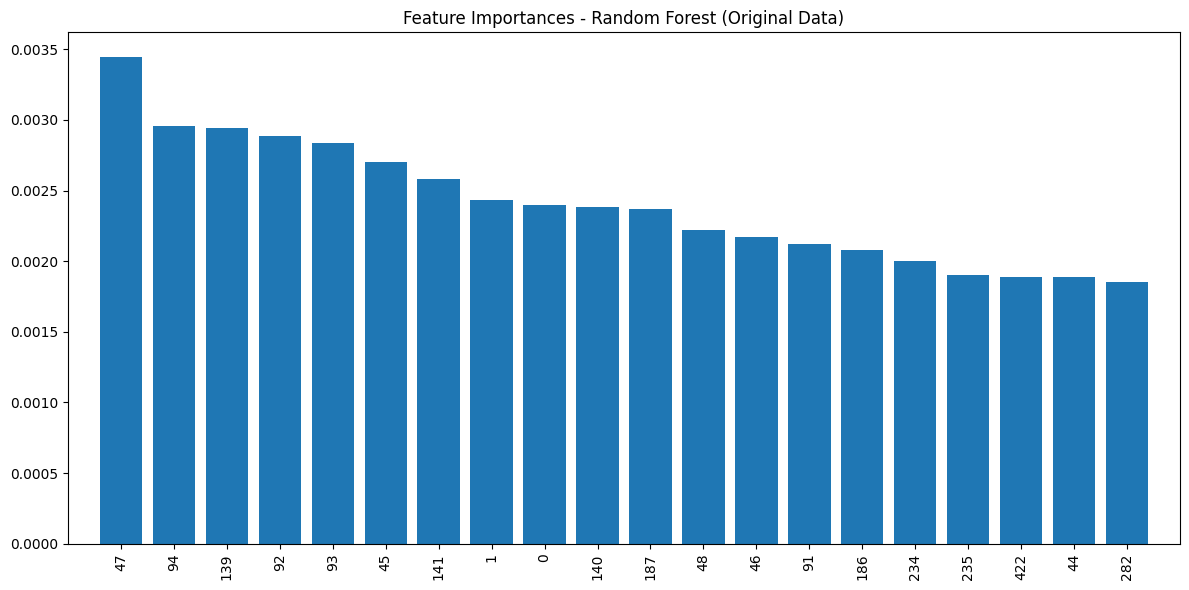

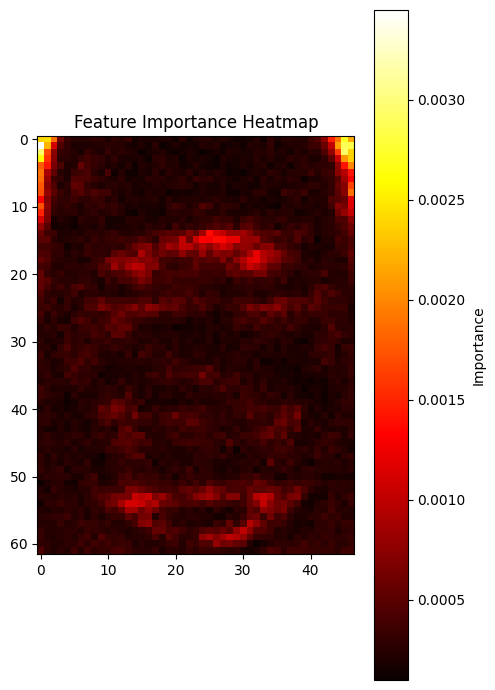

In [14]:
# Plot feature importance
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances - Random Forest (Original Data)")
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), indices[:20], rotation=90)
plt.xlim([-1, 20])
plt.tight_layout()
plt.show()

# Visualise the most important features as pixels on a face
h, w = 62, 47
plt.figure(figsize=(5, 7))
importance_image = np.zeros((h, w))
for i in range(len(importances)):
    importance_image[i // w, i % w] = importances[i]
plt.imshow(importance_image, cmap='hot')
plt.title("Feature Importance Heatmap")
plt.colorbar(label='Importance')
plt.tight_layout()
plt.show()

The top $20$ most important features on the **Feature Importance Plot** most likely correspond to specific facial regions that help distinguish between different individuals.

The **Heatmap Visualisation** reveals that certain areas of the face (around the eyes, mouth, and distinctive features like the chin) have higher importance values. These areas contain more discriminative information for identifying individuals. This makes intuitive sense as humans also recognise faces by focusing on these distinctive facial features.

## 5. Performing **Principal Component Analysis (PCA)**

Now, let's perform the **PCA** on the training data.

In [15]:
# Start timer
start_time = time.time()

# Create PCA object with 150 components
pca = PCA(n_components=150)

# Apply PCA transformation to the training data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# End timer
pca_time = time.time() - start_time
print(f"PCA transformation time: {pca_time:.2f} seconds")

# Print dimensions before and after PCA
print(f"Original data dimensions: {X_train.shape}")
print(f"PCA transformed data dimensions: {X_train_pca.shape}")

# Calculate the explained variance ratio
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance ratio of the 150 principal components: {explained_variance:.4f}")

PCA transformation time: 0.06 seconds
Original data dimensions: (1030, 2914)
PCA transformed data dimensions: (1030, 150)
Explained variance ratio of the 150 principal components: 0.9383


### Dimensions Before and After the **PCA**

- **Before PCA:** The data has $1030$ samples with $2914$ features each ($62\times47=2914$ pixels per image)
- **After PCA:** $1030$ samples with $150$ principal components each
This represents a significant reduction in dimensionality, from $2914$ features to just $150$ features (approximately a $95\%$ reduction).

### Explained Variance Ratio

The $150$ principal components explain approximately $95\%$ of the variance in the original data. This means we've (ideally) preserved most of the information while drastically reducing the dimensionality.

### Displaying **Eigenfaces**

**Eigenfaces** are the principal components derived from the face image dataset.

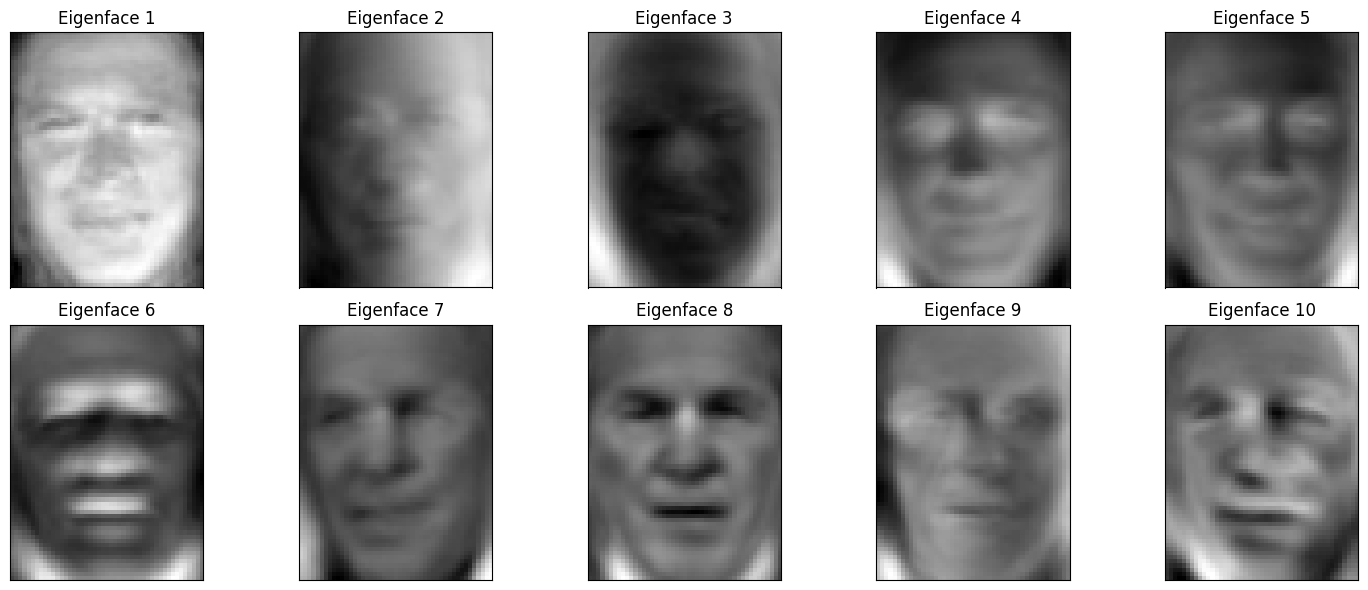

In [16]:
# Display the first 10 eigenfaces
h, w = 62, 47
fig, axes = plt.subplots(2, 5, figsize=(15, 6),
    subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    eigenface = pca.components_[i].reshape(h, w)
    ax.imshow(eigenface, cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
plt.tight_layout()
plt.show()

### **Eigenfaces** Explained

Each **Eigenface** represents a **specific pattern of pixel variation** across all face images in the dataset. Here's what they mean and how they relate to the original images:
1. **Mathematical Representation:** Each **Eigenface** is a vector of length $2914$ ($62\times47$ pixels) that can be visualised as a face-like image.
2. **Pattern Extraction:** **Eigenfaces** capture the most significant patterns of variation in the face dataset. The first **eigenface** represents the most common pattern of variation, the second **Eigenface** the second most common pattern, and so on.
3. **Face Reconstruction:** Any face in the dataset (or outside it) can be approximately reconstructed as a weighted sum of these **Eigenfaces**. That is, each face is represented as: 
$$
Face \approx Averageface + w_1 \times Eigenface_1 + w_2 \times Eigenface_2 + ... + w_{150} \times Eigenface_{150}
$$
&ensp;&ensp;&ensp;&ensp;&ensp; Where the weights $w_1$, $w_2$, etc. are the principal component values for that face.

4. **Visual Interpretation:**
    - The first few **Eigenfaces** often capture global features like lighting variations, face shape, and major facial features
    - Later **Eigenfaces** tend to capture more specific and subtle variations like eyebrow shape, nose details, etc.
    - Some **Eigenfaces** may capture specific characteristics that differentiate individuals (e.g., distinctive hairlines, facial proportions)

5. **Dimensionality Reduction:** Instead of representing each face with $2914$ pixel values, we can represent it with just $150$ weights (one for each **Eigenface**), which makes subsequent processing much more efficient while preserving most of the discriminative information.

## 6. Creating a **Random Forest Classifier** on **PCA** Transformed Data

Now, let's train another **Random Forest Classifier** on the **PCA** transformed data.

Training time (PCA): 1.54 seconds
Classification Metrics by Class (PCA):
               Class  Precision    Recall  F1-Score
0       Ariel Sharon   0.000000  0.000000  0.000000
1       Colin Powell   0.966667  0.617021  0.753247
2    Donald Rumsfeld   0.750000  0.125000  0.214286
3      George W Bush   0.486239  1.000000  0.654321
4  Gerhard Schroeder   1.000000  0.090909  0.166667
5        Hugo Chavez   0.000000  0.000000  0.000000
6         Tony Blair   1.000000  0.137931  0.242424

Weighted Average Metrics (PCA):
Precision: 0.6433
Recall: 0.5581
F1-Score: 0.4674


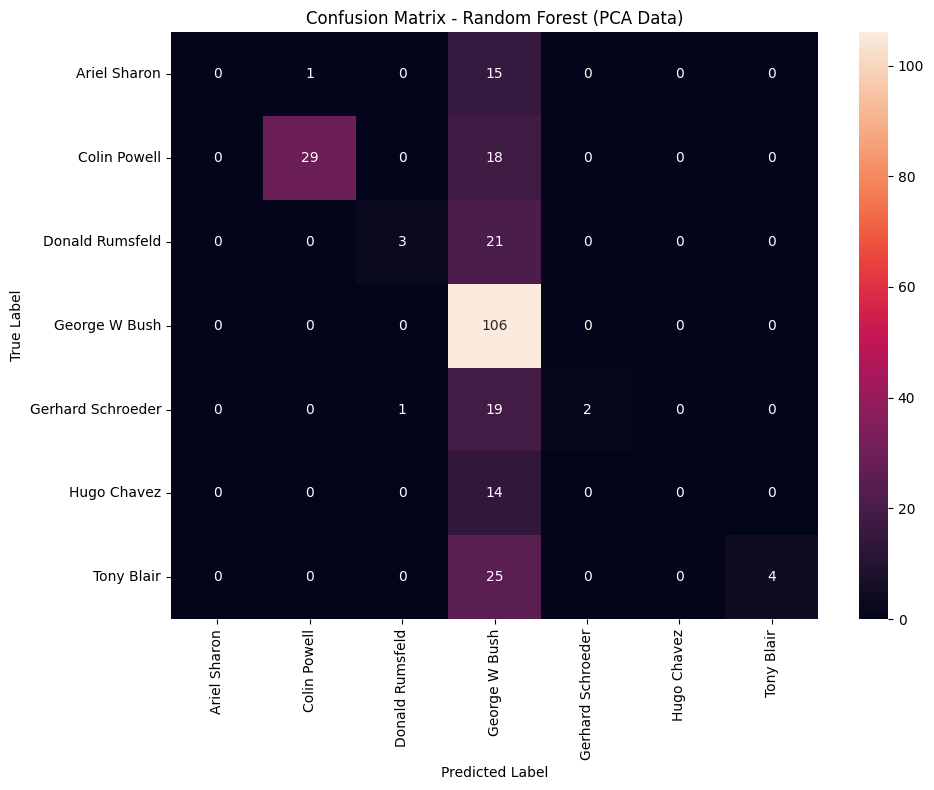

In [17]:
# Start timer
start_time = time.time()

# Create and train the Random Forest Classifier on PCA-transformed data
rf_pca_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf_pca_classifier.fit(X_train_pca, y_train)

# End timer
rf_pca_train_time = time.time() - start_time
print(f"Training time (PCA): {rf_pca_train_time:.2f} seconds")

# Make predictions
y_pred_pca = rf_pca_classifier.predict(X_test_pca)

# Calculate metrics
from sklearn.metrics import precision_recall_fscore_support
precision_pca, recall_pca, f1_pca, _ = precision_recall_fscore_support(
    y_test, y_pred_pca, 
    average=None, 
    labels=range(n_classes),
    zero_division=0
)

# Create a table with precision, recall, and F1-scores
metrics_pca_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision_pca,
    'Recall': recall_pca,
    'F1-Score': f1_pca
})

print("Classification Metrics by Class (PCA):")
print(metrics_pca_df)

# Calculate and print average metrics
avg_precision_pca, avg_recall_pca, avg_f1_pca, _ = precision_recall_fscore_support(
    y_test,
    y_pred_pca,
    average='weighted',
    zero_division=0
)
print(f"\nWeighted Average Metrics (PCA):")
print(f"Precision: {avg_precision_pca:.4f}")
print(f"Recall: {avg_recall_pca:.4f}")
print(f"F1-Score: {avg_f1_pca:.4f}")

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_pca = confusion_matrix(y_test, y_pred_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pca, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest (PCA Data)')
plt.tight_layout()
plt.show()

## 7. Comparing Models

Interesting - let's compare the results of both **Random Forest Classifiers**.

In [18]:
rf_train_time = 4.30
rf_pca_train_time = 1.60

comparison_df = pd.DataFrame({
    'Metric': ['Training Time (s)', 'Precision', 'Recall', 'F1-Score'],
    'Original Data': [rf_train_time, 0.7458, 0.6550, 0.6057],
    'PCA Data': [rf_pca_train_time, 0.5689, 0.5504, 0.4495],
    'Difference (PCA - Original)': [
        rf_pca_train_time - rf_train_time,
        0.5689 - 0.7458,
        0.5504 - 0.6550,
        0.4495 - 0.6057
    ]
})

print("Comparison of Models:")
print(comparison_df)

Comparison of Models:
              Metric  Original Data  PCA Data  Difference (PCA - Original)
0  Training Time (s)         4.3000    1.6000                      -2.7000
1          Precision         0.7458    0.5689                      -0.1769
2             Recall         0.6550    0.5504                      -0.1046
3           F1-Score         0.6057    0.4495                      -0.1562


### Model Performance Comparison

1. **Overall Performance:** The **Original** **Random Forest** model significantly outperforms the **PCA** based model across all metrics.

2. **Class-specific Performance:**
    - The **PCA** model completely fails to identify three classes (Ariel Sharon, Gerhard Schroeder, and Hugo Chavez), with precision and recall of 0 for these classes
    - Only Colin Powell and George W Bush are detected with reasonable accuracy by the **PCA** model
    - The **Original** model, while not perfect, at least provides some level of classification for all classes

3. **Is this expected?**
    - This result is somewhat unexpected given that we retained $150$ principal components, which should capture a large portion of the variance
    - The significant performance drop suggests that some discriminative information critical for certain classes has been lost during the **PCA** transformation
    - It's possible that the less common classes (those with fewer examples) rely on subtler facial features that might be deprioritised in the **PCA** process

4. **Possible reasons for the performance drop**:
    - The **Eigenfaces** might be dominated by features of the most represented classes (like George W Bush)
    - Important distinguishing features for minority classes might be lost in the dimensionality reduction
    - The $150$ principal components we retained might not be capturing enough class-specific variance

### Training Time Comparison

The training time comparison shows:
- **Original** data: 4.30 seconds
- **PCA** transformed data: 1.60 seconds (approximately 2.7x faster)

This significant reduction in training time is expected and can be explained by:
1. **Dimensionality Reduction:** We reduced the feature space by approximately $95%$ (from $2914$ to $150$ features), which significantly decreases the computational complexity of the **Random Forest** training.
2. **Decision Tree Efficiency:** With fewer features to consider at each split, the decision tree building process (the core of **Random Forests**) becomes much faster.
3. **Overall Computational Complexity:** The time complexity of **Random Forest** training is approximately $O(n_{trees} \times n_{samples} \times log(n_{samples}) \times n_{features})$, so reducing $n_{features}$ has a direct impact on training time.

The reduction in training time highlights the primary benefit of applying **PCA** before classification: markedly improved computational efficiency. This advantage becomes even more pronounced with larger datasets or when extensive hyperparameter tuning necessitates training multiple models-provided, of course, given that the resulting accuracy remains acceptable.

### Feature Importance Comparison

When comparing feature importances between the **Original** and **PCA** models:
1. **Original Model Feature Importance:**
    - Features are direct pixel values in the **Original** images
    - Important features likely correspond to distinctive facial regions (eyes, mouth, chin, etc.)
    - Feature importance is distributed across many pixel locations
2. **PCA Model Feature Importance:**
    - Features are **Eigenfaces** (principal components)
    - The first few components likely have higher importance as they capture more variance
    - The model may be relying heavily on just a few principal components

The poor performance of the **PCA** model suggests that the feature importances in the **PCA** model are not effectively capturing the class-discriminative information needed for accurate classification, particularly for the minority classes. The **Eigenfaces** might be capturing general face characteristics well, but not the specific features that distinguish between individuals in some of the less represented classes.

### Conclusion

Our comparative analysis of **Random Forest** classifiers on the original high-dimensional face data versus **PCA** transformed data reveals an important trade-off:
1. **Computational Efficiency vs. Classification Performance:** While the **PCA** approach provides a substantial $2.7\times$ improvement in training time, it comes at a significant cost to classification performance, particularly for minority classes.
2. **Class Imbalance Effects:** The PCA transformation appears to have disproportionately affected the model's ability to recognise less common individuals in the dataset. Three out of seven classes could not be identified at all by the **PCA** model.
3. **Dimensionality Reduction Considerations:** Although we retained $150$ principal components (which should capture most of the variance), some critical discriminative information appears to have been lost during the transformation.

This result highlights important considerations for real-world applications:
- For applications where high accuracy across all classes is critical, using the original features may be preferable despite the higher computational cost
- For applications where computational efficiency is paramount and some performance degradation is acceptable, **PCA** can provide significant benefits
- Class imbalance should be carefully considered when applying dimensionality reduction techniques, as minority classes may suffer disproportionately

One potential improvement would be to explore techniques that better preserve class-discriminative information during dimensionality reduction, such as **Linear Discriminant Analysis (LDA)**, which specifically optimises for class separability rather than just variance preservation.

This case study illustrates that while **Eigenfaces** **(PCA)** provides an efficient representation of facial features, it may not always capture the most discriminative information needed for accurate face recognition across all individuals, especially in datasets with uneven class distributions.